# Part I - Prosper Loans Data Exploration
## by Pedro Cruz

## Introduction
> Jupyter notebook prepared for the data exploration part of the 5th project for Udacity's Data Analyst Nanodegree.  
> The choosen dataset contains  information about 113,937 loan listings from Prosper, a marketplace for peer-to-peer loans.  
>
> The dataset have 81 variables. A data dictionaire is available here: https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0

## Custom Functions

In [1]:
def proportion_cat_plot(df, category_column, prop_increment=0.05, figsize=[12,6]):
    """
    Creates a horizontal bar chart with proportions of a category variable (category_column),
    from a given dataset (df).
    """
    cat_counts = df[category_column].value_counts()
    cat_order = cat_counts.index

    # 1. Compute largest proportion
    n_cat = cat_counts.sum()
    max_cat_count = cat_counts[0]
    max_prop = max_cat_count / n_cat

    # 2. establish tick locations
    tick_props = np.arange(0, max_prop+prop_increment, prop_increment)

    # 3. establish tick names
    tick_names = ['{:0.0%}'.format(v) for v in tick_props]

    # create plot
    base_color = sb.color_palette()[0]
    plt.figure(figsize = figsize)
    sb.countplot(data = df, y = category_column, color = base_color, order = cat_order)
    plt.xticks(tick_props * n_cat, tick_names)
    plt.xlabel('proportion')
    plt.title(category_column+' Proportions');
    
def to_ordered_category(df, ordinal_var_dict):
    """
    # using the same idea found in the diamonds example project
    
    Changes a column(s) format(s) in a given df to categorical, Using a
    dict of {key: list}, where key is a column that exists in the
    df, and list is a list of ordered categories for the values
    in that column.
    """
    for var in ordinal_var_dict:
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        df[var] = df[var].astype(ordered_var)
    return df

def income_percentile_filter(df, percentile):
    """
    custom function to filter the df on a
    specific percentile of the stated monthly
    income.
    """
    mask = df['StatedMonthlyIncome_USD(000)']<=np.percentile(df['StatedMonthlyIncome_USD(000)'], percentile)
    return df[mask]

def hist_with_aux_lines(data, range=None, binsize=0.01, ticksize=0.05, log_scale=False, show_mean=True, show_median=True, show_mode=True, format='%'):
    """
    Creates a histogram for a series (data) with optional vertical lines for mean,
    median and mode.
    The fuction also acepts a range for the data and can plot in standard or
    logarithmic scale.
    
    Credits:
    # vertical line(s) idea here: https://stackoverflow.com/a/52961228
    # legend for vertical line(s) here: https://stackoverflow.com/a/30282684
    # filter series with lambda function here: https://stackoverflow.com/a/38258528
    """    
    
    if range:
        series = data[lambda x: ((x>range[0])&(x<=range[1]))]
    else:
        series = data
    
    # options for bins and x-axis labels, according to
    # the varible log_scale
    
    binsize = binsize
    ticksize = ticksize
    min_value = series.min()
    max_value = series.max()

    if log_scale:
        min_logvalue = np.log10(min_value)
        max_logvalue = np.log10(max_value)
        bins = 10 ** np.arange(min_logvalue, max_logvalue+binsize, binsize)
        ticks = [0.01, 0.02, 0.05, 0.1, 0.2, max_value]
    else:
        bins = np.arange(min_value, max_value+binsize, binsize)
        ticks = np.arange(min_value, max_value, ticksize)
    
    # CLEAN THE TICKS LIST
    # this list comprehension will
    #  - return all the values between the range min_value - max_value.
    #  - return the min_value everytime a number falls outside the range
    ticks = [x if x >= min_value <=max_value else min_value for x in ticks]

    # as the ticks list may contain multiple itens with the min_value, here I
    # use the set() function, that returns only the unique values from a list.
    # Finally, convert it again to list and sort.
    ticks = list(set(ticks))
    ticks.sort()
    
    # format of the x axis labels, according to how many
    # points there is to plot.
    if format=='%':
        if len(ticks) > 10:
            labels_format = '{:0.0%}'
        else:
            labels_format = '{:0.2%}'
    else:
        # not percentage. Convert to float
        ticks = 100 * ticks
        if len(ticks) > 10:
            labels_format = '{:0.0f}'
        else:
            labels_format = '{:0.2f}'
    
    tick_labels = [labels_format.format(v) for v in ticks]

    # create the plot
    plt.figure(figsize=(20, 7))
    plt.hist(x = series, bins = bins)
    if log_scale:
        plt.xscale('log')
        plt.xlabel('x-axis limits are changed, and scaled to log-type')
        plt.title('log distribution of the '+series.name+' variable')
    else:
        plt.xlabel(series.name)
        plt.title('distribution of the '+series.name+' variable')        
    
    # Apply the custom x-ticks
    plt.xticks(ticks, tick_labels)

    # PROBLEM (bug?)
    # some tick points kept showing scientific notation, despite the
    # use of xticks().
    # Latter discovered that the problem was the "minor ticks"
    # solution here: https://stackoverflow.com/a/10781270
    plt.minorticks_off()

    if show_mean or show_median or show_mode:
        min_ylim, max_ylim = plt.ylim()

    if show_mean:
        mean_rate = series.mean()
        plt.axvline(mean_rate, color='red', linestyle='-', linewidth=2, label='Mean: '+labels_format.format(mean_rate))
        
    if show_median:
        median_rate = series.median()
        plt.axvline(median_rate, color='orange', linestyle='-', linewidth=2, label='Median: '+labels_format.format(median_rate))
        
    if show_mode:
        # mode() returns a series, so the [0]
        mode_rate = series.mode()[0]
        plt.axvline(mode_rate, color='green', linestyle='-', linewidth=2, label='Mode: '+labels_format.format(mode_rate))
    if show_mean or show_median or show_mode:
        plt.legend(loc='upper right')
    plt.show()
    
    # CUSTOM FUNCTION FOR MULTIVARIATE PLOTS

def regplot_three_var(df, x, y, third_var, markers=[[True, 'o'],[False, 's']]):
    """
    Custom function for regplots with three variables and correlation
    shown in the legend.
    """
    
    cat_markers = markers
    legend_list = []

    fig, ax = plt.subplots(figsize=[15,8])
    for cat, marker in cat_markers:
        df_cat = df[df[third_var] == cat]
        sb.regplot(ax=ax, data=df_cat, x=x, y=y, x_jitter=0.1, y_jitter=0.01, scatter_kws={'alpha':0.30}, truncate=False,\
                   marker=marker)\
        .set(title=x+' vs '+y+' | color by '+third_var)

        legend_list.append(str(cat)+' (corr: '+str(round(df_cat[[x, y]].corr().loc[x, y],2))+')')

    plt.legend(legend_list)

    plt.show();

## Preliminary Wrangling

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [3]:
df = pd.read_csv('prosperLoanData.csv')

In [4]:
print(df.shape)

(113937, 81)


In [6]:
print(df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

In [7]:
# check categorical columns for invalid values

# ProsperScore: from 1 to 10
print(f"ProsperScore: {np.sort(df['ProsperScore'].unique())}")

# ProsperRating (numeric) from 0 to 7
print(f"ProsperRating (numeric): {np.sort(df['ProsperRating (numeric)'].unique())}")

# ProsperRating (numeric) from AA, A, B, C, D, E, HR
print(f"ProsperRating (Alpha): {df['ProsperRating (Alpha)'].unique()}")

print(f"IncomeRange: {df['IncomeRange'].unique()}")


ProsperScore: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]
ProsperRating (numeric): [ 1.  2.  3.  4.  5.  6.  7. nan]
ProsperRating (Alpha): [nan 'A' 'D' 'B' 'E' 'C' 'AA' 'HR']
IncomeRange: ['$25,000-49,999' '$50,000-74,999' 'Not displayed' '$100,000+'
 '$75,000-99,999' '$1-24,999' 'Not employed' '$0']


In [8]:
# found invalid ProsperScore of 11
(df['ProsperScore']==11).sum()

1456

In [9]:
# check for nan in the BorrowerAPR column (feature of interest)
df['BorrowerAPR'].isna().sum()

25

In [10]:
# check for duplicated rows.
# the column LoanKey was used for this purpose, as the data dictionaire states that this
# is a UNIQUE key for each loan.
df['LoanKey'].duplicated(keep=False).sum()

1698

#### issues

* datetime columns formatted as strings instead of datetime: "listingcreationdate", "ClosedDate", "LoanOriginationDate", "DateCreditPulled"
* numeric category column "listingcategory" needs apropriate translation.
* convert "IncomeRange", "ProsperScore" and "ProsperRating (both numeric and alpha)" into ordered categorical types
* categorical column "ProsperScore" contains invalid value (valid range from 1 to 10. There are 1,456 rows with a 11)
* there are 25 nans rows in the  BorrowerAPR column
* there are 1,698 duplicated rows in the dataset

### Data Cleaning

In [11]:
df_clean = df.copy()

#### define

there 25 nans in the 'BorrowerAPR' column
* drop all those rows, as this column is the most important for this exploration and there should be no nans

#### code

In [12]:
# drop nan rows from the 'BorrowerAPR'
df_clean = df_clean[~df_clean['BorrowerAPR'].isna()]

In [13]:
df_clean['BorrowerAPR'].isna().sum()

0

#### define

found 1,698 duplicated rows when looking to the LoanKey column.
this means that some other column have different values for the
same LoanKey.

to find the column that is duplicating the data (the one with different values for the same LoanKey)
I will loop trough all combinations LoanKey and each other column in the dataset.

the funcion duplicated() on the combination of LoanKey and each other column will
return:
* 1,698 rows when the other column has exactly one value for each LoanKey. These cases means that
this other column is being affected by the problem, ie. it is not the column duplicating the rows.
* zero rows when the other column has no duplicated values in relation to LoanKey. This case(s)
means that this column(s) is duplicating the rows in the dataframe, affecting all the other columns.

In [14]:
# first create a dictionary
duplicated_rows_dict = dict()

# loop trough all columns, checking the number of duplicated
# rows and storing the number of returned rows in the dict.
for col in df_clean.columns.to_list():
    duplicated_rows_dict[col] = df_clean[df_clean[["LoanKey",col]].duplicated(keep=False)].shape[0]

# use the dictionary to create a dataframe
duplicated_rows_df = pd.DataFrame.from_dict(duplicated_rows_dict, orient='index').reset_index()
duplicated_rows_df.columns=['column','duplicated rows']

# sort the dataframe to find the column(s) with
# different values for the same LoanKey (i.e. the
# one(s) with zero duplicated rows)
print(f'List of duplicated rows:')
duplicated_rows_df.sort_values('duplicated rows')

List of duplicated rows:


,column,duplicated rows
15,ProsperScore,0
0,ListingKey,1698
58,ScorexChangeAtTimeOfListing,1698
57,ProsperPrincipalOutstanding,1698
56,ProsperPrincipalBorrowed,1698
...,...,...
24,DateCreditPulled,1698
23,GroupKey,1698
22,CurrentlyInGroup,1698
79,InvestmentFromFriendsAmount,1698


#### define (duplicated rows continuation)
found that the column duplicating the rows in the dataframe is the "ProsperScore".  

To deal with the duplicated rows I need to decide what to do with the duplicated
values in this column.  

The ProsperScore contains a score ranging between 1 and 10. As the score is numeric in nature, it is possible to use numeric operations.  Considering this, I decided to get, for each LoanKey, the mean of the scores duplicated and round it to the nearest integer (as the score is comprised only of whole numbers), and limit it to 10, as it is the max value available for the column.  
Finally, we drop the duplicates of the original dataframe and replace the old prosperscore with the calculated new scores.

#### code

In [15]:
# get the mean of the ProsperScore for each LoanKey
df_adj_score = df_clean[df_clean['LoanKey'].duplicated(keep=False)][['LoanKey','ProsperScore']]\
.groupby('LoanKey').mean()\
.reset_index()

# rename columns
df_adj_score.columns = ['LoanKey', 'ProsperScore_adjusted']

# round the adjusted score to the nearest integer (rounding lambda here: https://stackoverflow.com/a/68060638)
# use the min function to lower the cases with 11s to 10s
df_adj_score['ProsperScore_adjusted'] = df_adj_score['ProsperScore_adjusted'].apply(lambda x: min(10,int(x+0.5)))

In [16]:
# drop the duplicates from the df_clean, leaving only one row
# for each LoanKey.
# irrelevant which row will be kept, as the new ProsperScore
# will be the one calculated in the cell above.

df_clean.drop_duplicates(subset=['LoanKey'], inplace=True)

In [17]:
# merge the datasets, creating the column "ProsperScore_adjusted" in the df_clean
df_clean = pd.merge(left=df_clean, right=df_adj_score, on='LoanKey', how='left')

# update the "ProsperScore" column, keepping the value of ProsperScore where there is no ProsperScore_adjusted
df_clean['ProsperScore'] = np.where(df_clean['ProsperScore_adjusted'].isna(),df_clean['ProsperScore'], df_clean['ProsperScore_adjusted'])

# drop the extra column
df_clean.drop(columns='ProsperScore_adjusted', inplace=True)

#### test

In [18]:
print("number of duplicated rows")
print(f"\tbefore cleaning: {df[df['LoanKey'].duplicated(keep=False)].shape[0]}")
print(f"\tafter cleaning: {df_clean[df_clean['LoanKey'].duplicated(keep=False)].shape[0]}")

number of duplicated rows
	before cleaning: 1698
	after cleaning: 0


#### define
for the "ProsperScore" column:
* Fill nan with 1, considering those cases that doesn't have a score as the lowest score available.  
* Replace the invalid score 11 with 10, considering those with a score higher than the max valid value available as 10, which is the max valid score available

#### code

In [19]:
df_clean['ProsperScore'].fillna(1, inplace=True)
df_clean['ProsperScore'].replace(to_replace=11, value=10, inplace=True)

#### test

In [20]:
df_clean['ProsperScore'].value_counts().sort_index()

1.0     29976
2.0      5684
3.0      7547
4.0     12412
5.0      9786
6.0     12189
7.0     10490
8.0     11967
9.0      6885
10.0     6105
Name: ProsperScore, dtype: int64

#### define
convert "IncomeRange", "ProsperScore" and "ProsperRating (both numeric and alpha)" into ordered categorical types  
Regarding the ProsperScore, create an aditional variable, to keep the numeric format, as a numeric variable is necessary for some kinds of plots.

#### code

In [21]:
# create the ProsperScore numeric variable
df_clean['ProsperScore (num)'] = df_clean['ProsperScore'].astype(int)

# change the types of the categorical columns
cat_columns = {'ProsperRating (Alpha)': ['HR','E','D','C','B','A','AA'],
               'ProsperRating (numeric)': [0,1, 2, 3, 4, 5,6,7],
               'ProsperScore': [1,2,3,4,5,6,7,8,9,10],
               'IncomeRange': ['Not displayed','Not employed','$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999','$75,000-99,999','$100,000+']
              }

df_clean = to_ordered_category(df_clean, cat_columns)

#### test

In [22]:
cols = ['ProsperRating (numeric)','ProsperRating (Alpha)','IncomeRange', 'ProsperScore', 'ProsperScore (num)']
print(df_clean[cols].dtypes)
df_clean[cols].head()

ProsperRating (numeric)    category
ProsperRating (Alpha)      category
IncomeRange                category
ProsperScore               category
ProsperScore (num)            int32
dtype: object


,ProsperRating (numeric),ProsperRating (Alpha),IncomeRange,ProsperScore,ProsperScore (num)
0,NaN,NaN,"$25,000-49,999",1,1
1,6,A,"$50,000-74,999",7,7
2,NaN,NaN,Not displayed,1,1
3,6,A,"$25,000-49,999",9,9
4,3,D,"$100,000+",4,4


#### define
convert columns "listingcreationdate", "ClosedDate", "LoanOriginationDate", "DateCreditPulled" to date format

#### code

In [23]:
date_cols = ['ListingCreationDate','ClosedDate','LoanOriginationDate','DateCreditPulled','FirstRecordedCreditLine']

for col in date_cols:
    try:
        df_clean[col] = pd.to_datetime(df_clean[col]).dt.to_period('D')
    except:
        pass

#### test

In [24]:
print(df_clean[date_cols].dtypes)
df_clean[date_cols].head()

ListingCreationDate        period[D]
ClosedDate                 period[D]
LoanOriginationDate        period[D]
DateCreditPulled           period[D]
FirstRecordedCreditLine    period[D]
dtype: object


,ListingCreationDate,ClosedDate,LoanOriginationDate,DateCreditPulled,FirstRecordedCreditLine
0,2007-08-26,2009-08-14,2007-09-12,2007-08-26,2001-10-11
1,2014-02-27,NaT,2014-03-03,2014-02-27,1996-03-18
2,2007-01-05,2009-12-17,2007-01-17,2007-01-02,2002-07-27
3,2012-10-22,NaT,2012-11-01,2012-10-22,1983-02-28
4,2013-09-14,NaT,2013-09-20,2013-09-14,2004-02-20


#### define
translate "listingcategory" numbers to actual listing categories, according to the codification available in the data dictionaire.

#### code

In [25]:
# listing category numbers to actual categories

listingcat = {0: 'Not Available',
              1: 'Debt Consolidation',
              2: 'Home Improvement',
              3: 'Business',
              4: 'Personal Loan',
              5: 'Student Use',
              6: 'Auto',
              7: 'Other',
              8: 'Baby&Adoption',
              9: 'Boat',
              10: 'Cosmetic Procedure',
              11: 'Engagement Ring',
              12: 'Green Loans',
              13: 'Household Expenses',
              14: 'Large Purchases',
              15: 'Medical/Dental',
              16: 'Motorcycle',
              17: 'RV',
              18: 'Taxes',
              19: 'Vacation',
              20: 'Wedding Loans'
             }
df_clean['ListingCategory'] = df_clean['ListingCategory (numeric)'].replace(listingcat)

#### test

In [26]:
df_clean['ListingCategory'].unique()

array(['Not Available', 'Home Improvement', 'Motorcycle',
       'Debt Consolidation', 'Other', 'Household Expenses', 'Auto',
       'Medical/Dental', 'Wedding Loans', 'Vacation', 'Business', 'Taxes',
       'Baby&Adoption', 'Personal Loan', 'Engagement Ring',
       'Large Purchases', 'Student Use', 'Boat', 'RV',
       'Cosmetic Procedure', 'Green Loans'], dtype=object)

## exploratory data analysis

### What is the structure of your dataset?

There are 113,937 loan listings in the dataset with 81 features. Most variables are numeric in nature, but the variables "ProsperRating (Alpha)", "ProsperRating (numeric)", "ProsperScore" and "IncomeRange" are ordered factor variables with the following levels.

(worst) ——> (best)  
ProsperRating (Alpha): HR,E,D,C,B,A,AA  
ProsperRating (numeric): 0,1, 2, 3, 4, 5,6,7  
ProsperScore: 1,2,3,4,5,6,7,8,9,10  
IncomeRange: Not displayed,Not employed,$0, $1-24,999, $25,000-49,999, $50,000-74,999,$75,000-99,999,$100,000+

### What is/are the main feature(s) of interest in your dataset?

I want to find which features impact the "BorrowerAPR" (Annual Percentage Rate) for the loan.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I believe that income ("IncomeRange" and "StatedMonthlyIncome") and "ProsperScore" are the most important features when defining the APR.

## Univariate Exploration

#### question
What is the distribution of the feature of interest?

#### visualization

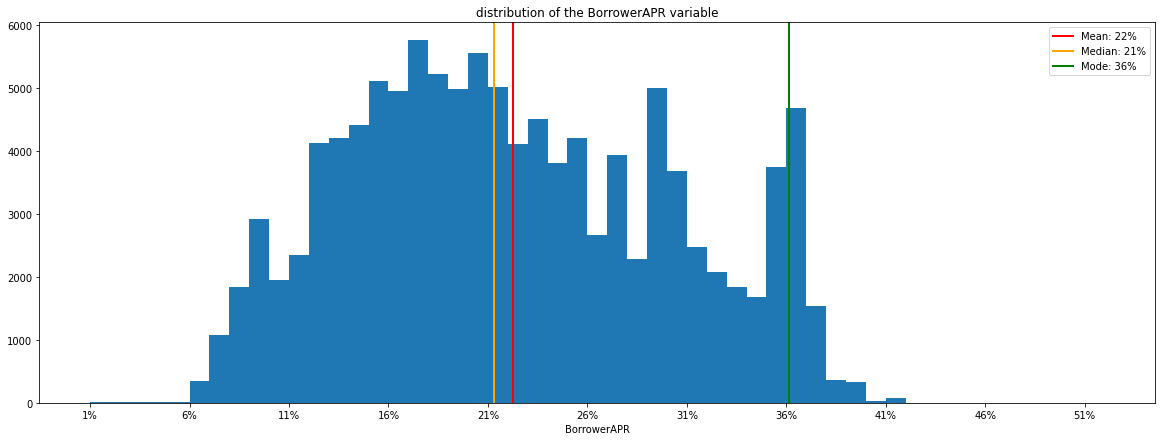

In [27]:
# start with a standard-scaled plot
# using custom function, as I will use the same plot multiple times
hist_with_aux_lines(df_clean['BorrowerAPR'], binsize=0.01, ticksize=0.05)

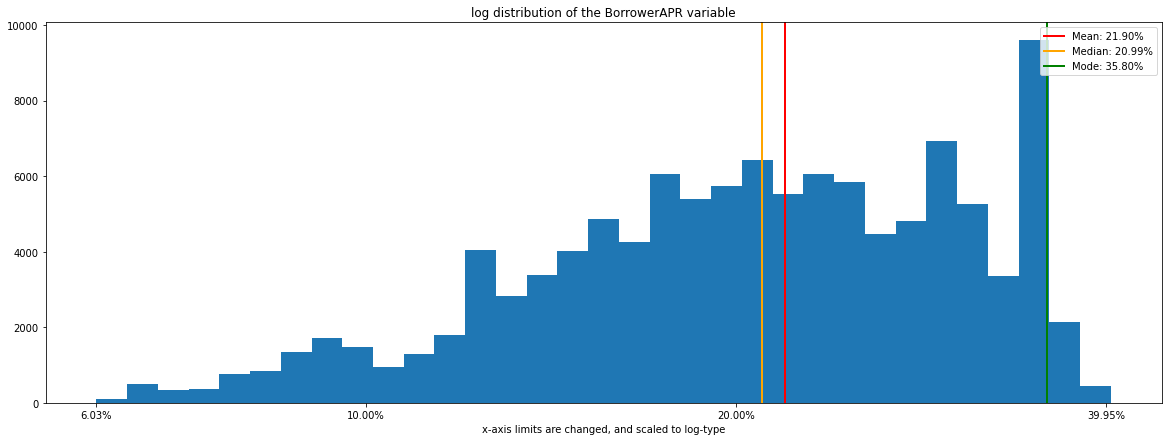

In [28]:
# plotting the data on a log scale, looking for aditional information
hist_with_aux_lines(df_clean['BorrowerAPR'], binsize=0.025, ticksize=0.05, log_scale=True, range=(0.06, 0.40))

#### observations
The distribution on a standard scale seems roughly normal, with a peak spike around 35%. Also, the distribution is right skewed, suggesting outliers above the 40% annual rate.

It was not possible to gather any other relevant information from the log scaled plot. The same peak around 35% annual rate appears in this scale.

#### question

Are there any reasons for the spike around 35% annual rate?

#### visualization

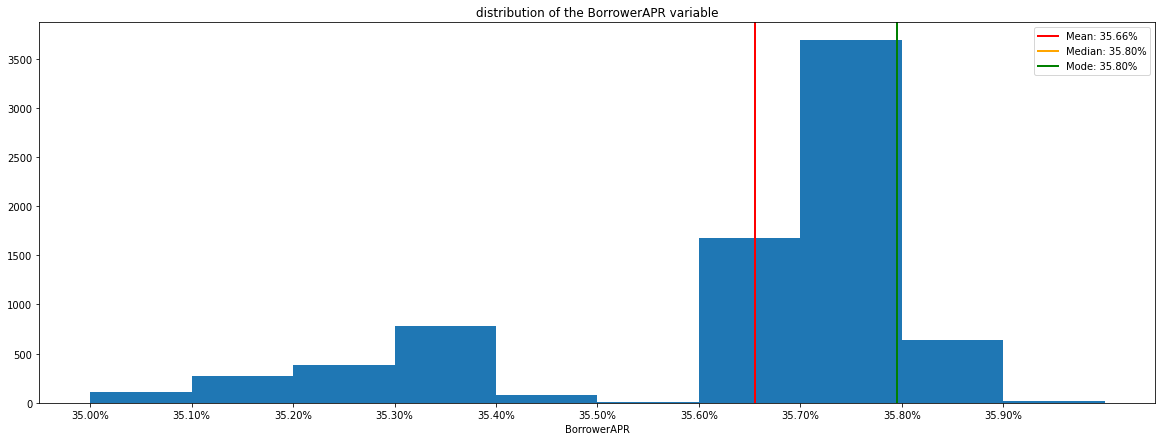

In [29]:
# zoom in the 35 to 36% range
hist_with_aux_lines(data=df_clean['BorrowerAPR'], range=(0.35, 0.36), binsize=0.001, ticksize=0.001)

#### Observations

Looking closely, the peak is in the interval between 35.70% and 35.80%.

In [30]:
# zoom in the interval 35.70 - 35.80
df_clean[(df_clean['BorrowerAPR']>=0.357)&(df_clean['BorrowerAPR']<=0.358)]['BorrowerAPR'].value_counts()

0.35797    3672
0.35778      10
0.35717       2
0.35758       1
0.35772       1
0.35701       1
Name: BorrowerAPR, dtype: int64

In [31]:
# the rate with most loans is 0.35797
# checking adicional info
print('APR of 0.35797')
print(f"\tnumber of loans: {df_clean[df_clean['BorrowerAPR']==0.35797].shape[0]}")
print(f"\t% of total loans: {df_clean[df_clean['BorrowerAPR']==0.35797].shape[0]/ df.shape[0]}")
print(f"\t mode of all loans: {df_clean['BorrowerAPR'].mode()[0]}")

APR of 0.35797
	number of loans: 3672
	% of total loans: 0.03222833671239369
	 mode of all loans: 0.35797


oddly, there is a lot of loans in the 35,797% rate (in fact, 3,672 loans, or 3.22% of all loans), which also happens to be the mode of the series.  
Maybe that is a kind of a standard rate?  

#### question
What is the ProsperScore of the extremely high annual rates loans (outliers above 40%)?

#### visualization

num of loans with >40% APR: 102


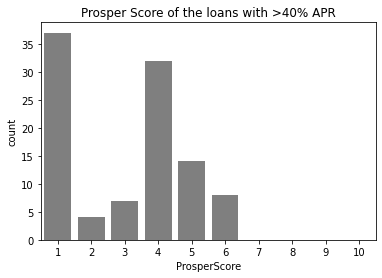

In [32]:
outliers =  (df_clean['BorrowerAPR'] > 0.4)

print(f'num of loans with >40% APR: {outliers.sum()}')

base_color = sb.color_palette()[7]

sb.countplot(data=df_clean[outliers], x='ProsperScore', color=base_color).set(title='Prosper Score of the loans with >40% APR');

#### observations

As expected, most of the outliers in the range above 40% of annual percentage rate (APR) have low Prosper scores, with most of them with a score of 1.0 (the lowerst one), many others with 4.0 and not a single one above 6.0, suggesting they are riskier borrowers, for whom the lenders will expect higher rates to justify the risk.

#### question

Regarding income, what insights could be extracted from the distributions of the "StatedMonthlyIncome" and IncomeRange feature?

#### visualization

In [33]:
# first looking for the statistics
df_clean['StatedMonthlyIncome'].describe()

count    1.130410e+05
mean     5.604058e+03
std      7.495438e+03
min      0.000000e+00
25%      3.198167e+03
50%      4.666667e+03
75%      6.812500e+03
max      1.750003e+06
Name: StatedMonthlyIncome, dtype: float64

In [34]:
# feature engineering
# as the income values are high the numbers got truncated, so I will create a new column with the income in thousands of USD
df_clean['StatedMonthlyIncome_USD(000)'] = df_clean['StatedMonthlyIncome'].apply(lambda x: round(x/1000, 0))

In [35]:
# get the statistics for the StatedMonthlyIncome
df_clean['StatedMonthlyIncome_USD(000)'].describe()

count    113041.000000
mean          5.592334
std           7.503290
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max        1750.000000
Name: StatedMonthlyIncome_USD(000), dtype: float64

In [36]:
# as the 75% percentile is only 7k while the max value is 1,750k, calculate
# higher percentiles to define where to plot the distribution.
var = df_clean['StatedMonthlyIncome_USD(000)']

percentiles = [75, 80, 85, 90, 95, 96, 97, 98, 99, 99.5, 99.6, 99.7, 99.8, 99.9, 99.99, 99.999, 100]
p_dict={}
for p in percentiles:
    p_dict[p] = np.percentile(var,p)

print('Custom percentiles of the StatedMonthlyIncome_USD(000)')

for k, v in p_dict.items():
    print(k, ' : ', v)

Custom percentiles of the StatedMonthlyIncome_USD(000)
75  :  7.0
80  :  8.0
85  :  8.0
90  :  10.0
95  :  12.0
96  :  13.0
97  :  14.0
98  :  16.0
99  :  20.0
99.5  :  25.0
99.6  :  27.0
99.7  :  30.0
99.8  :  33.0
99.9  :  44.0
99.99  :  146.95999999981723
99.999  :  601.2655999987619
100  :  1750.0


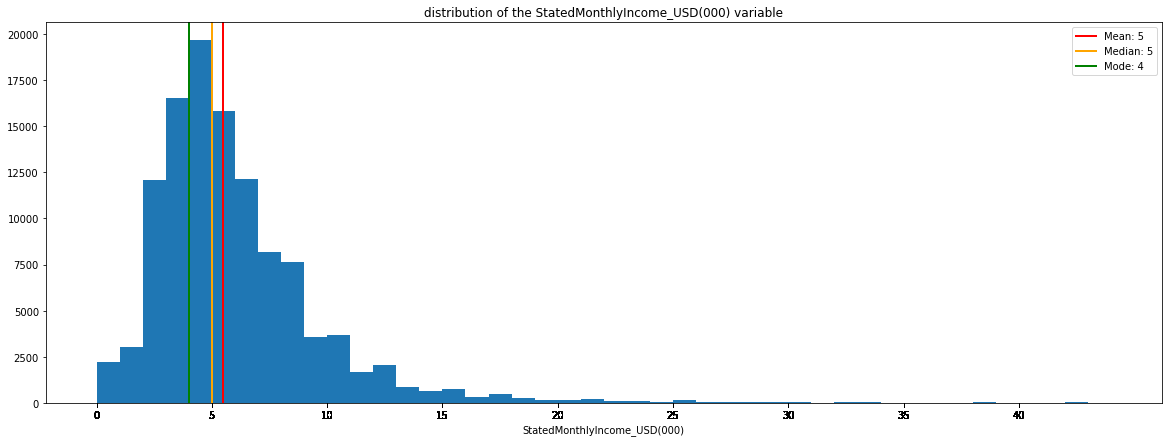

In [37]:
# to plot the histogram, it is necessary to limit the range, as there is a huge tail to the right,
# depending of the configuration, the hist function returns an error with all that data:

# ValueError: Maximum allowed size exceeded

# Considering this, I Decided to use the 99.9% percentile, which is 44k.

hist_with_aux_lines(data=income_percentile_filter(df_clean,99.9)['StatedMonthlyIncome_USD(000)'], binsize=1, ticksize=5, format='num')

#### observations

The distribution, even limited by the 99.9% percentile, is highly skewed to the right, suggesting that there are strong outliers to the right.

In [38]:
df_clean['IncomeRange'].value_counts()

$25,000-49,999    31940
$50,000-74,999    30749
$100,000+         17188
$75,000-99,999    16780
Not displayed      7716
$1-24,999          7241
Not employed        806
$0                  621
Name: IncomeRange, dtype: int64

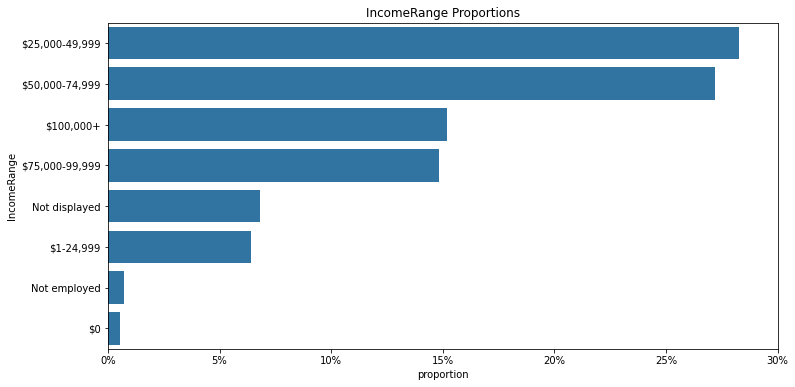

In [39]:
# Prosper user income profile

proportion_cat_plot(df_clean, 'IncomeRange')

#### observations

The majority of Prosper's users have an income in the ranges of 25k-50k and 50k-75k. combined, those ranges represent more than 50% of all loans

#### question

What is the most common purpose of the loans, as stated in the ListingCategory feature?

#### visualization

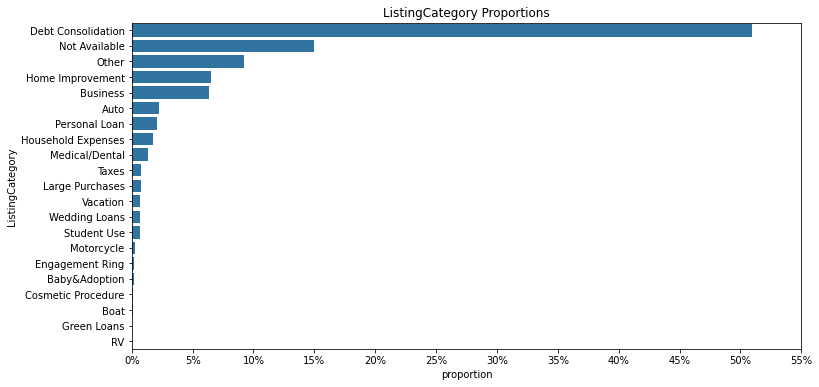

In [40]:
proportion_cat_plot(df_clean, 'ListingCategory')

#### observations
More than 50% of the loans were listed as debt consolidation, around 15% and 10% were listed with the indecifrables 'Not Available' and 'Other' categories, respectively. All the other categories, with more enlightning descriptions, represented less than 10% each.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The BorrowerAPR has a distribution roughly normal, with a peak around 35%, which in fact was found to be the rate of 35.797%. This rate alone represent 3.22% of all loans, strongly suggesting that this number is some kind of standard rate.
> I performed a log transformation on this data, but the log-scaled plot didn't provide any other useful insights into that data.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> The StatedMonthlyincome column has a extremily long tail to right. In fact it is not possible (in my computer) to plot the histogram with all the data, reason why I created an aditional column with the income in thousands of USD and also limited the histogram to a number that works without overplotting. This number was the 99.99% percentile, which is 44k.

## Bivariate Exploration

In [41]:
""" To focus the exploration on the most relevant items, I will limit the variables of interest to the ones with
    the strongest correlation (positive or negative) with the "BorrowerAPR" variable.

    Select the variables with the greatest correlations (both negative and positive) with the variable of interest.
    define the ranges as:
    * positive: >0.3 and <=1
    * negative: >=-1 and <-0.3 """


# find the variables with the strongest correlation

# credits:
# unstack correlation matrix here: https://stackoverflow.com/a/17778786
# filter series with lambda function here: https://stackoverflow.com/a/38258528
# selecting numeric columns here: https://stackoverflow.com/a/28155580

numericvariables = list(df_clean.select_dtypes(include=[np.number]).columns.values)

vars_strongest_correlated = df_clean[numericvariables].corr().unstack()['BorrowerAPR'][lambda x: ((x>0.3)&(x<=1))|((x<-0.3)&(x>=-1))]

#sort by absolute values, to find the strongest, positive or negative, correlations
vars_strongest_correlated = vars_strongest_correlated.sort_values(key=abs, ascending=False).iloc[0:15]

# create list with column names
cols_of_interest = vars_strongest_correlated.index.to_list()

# add 'ProsperScore (num)' as it is a relevant feature in the dataset
cols_of_interest = cols_of_interest+['ProsperScore (num)']

print(vars_strongest_correlated)

BorrowerAPR                1.000000
BorrowerRate               0.989817
LenderYield                0.989319
EstimatedLoss              0.949343
EstimatedEffectiveYield    0.894989
EstimatedReturn            0.793796
CreditScoreRangeLower     -0.429289
CreditScoreRangeUpper     -0.429289
AvailableBankcardCredit   -0.349179
LoanOriginalAmount        -0.322323
Investors                 -0.309448
dtype: float64


#### question

Which numeric features have the highest correlation with the "*BorrowerAPR*"?

#### visualization

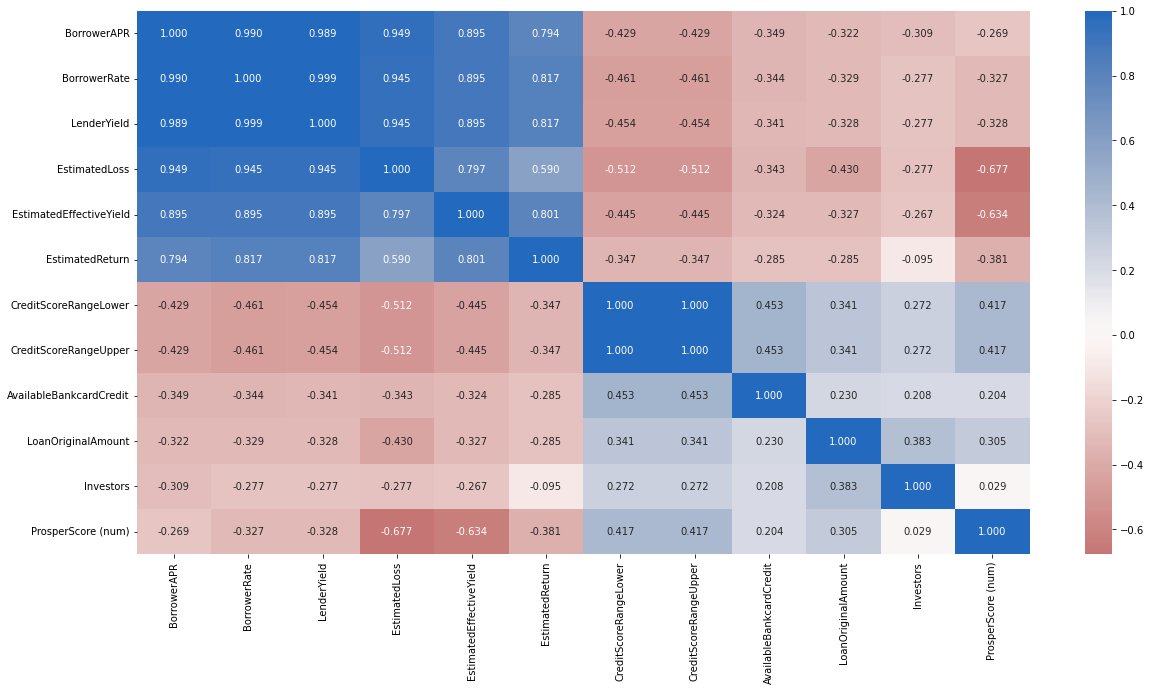

In [42]:
# plot idea from the example diamonds project

# to avoid overploting here, only the [cols_of_interest]
# are used (the ones with higher possibility to be relevant
# for the BorrowerAPR variable).

plt.figure(figsize = [20, 10])
sb.heatmap(df_clean[cols_of_interest].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

#### observations

Actually, the the columns with the highest correlations doesn't add much value to this part of the investigation.  
The "*BorrowerAPR*" have a high, or almost perfect, correlation with the cols "*BorrowerRate*", "*LenderYield*", "*EstimatedLoss*", "*EstimatedEffectiveYield*" and "*EstimatedReturn*", but considering the nature of those collumns, it is more beliavable that those numbers are influenced by the "*BorrowerAPR*", not the other way around.

Regarding the other columns, despite that the correlation is not as high as the ones mentioned above, considering its nature, it seems that they have an influence on the "*BorrowerAPR*".

Considering this, I will continue the investigation on those other columns, where the correlation is higher than 0.30.
"*CreditScoreRangeLower*", "*CreditScoreRangeUpper*", "*AvailableBankCardCredit*", "*LoanOriginalAmount*" and "*Investors*".

Also, it is worh mentioning that the weakest correlation seen in this matrix is the the number of investors vs the EstimatedReturn.For some reason, the higher rates doesn't drives more investors to make the investment.  
Another highlight is the correlation between the "ProsperScore" and the "EstimatedLoss" and "EstimatedEffectiveYield". This shows that the score created by Prosper is a good predictor of the estimated loss and effective yield.

Continuing the investigation, along with the numeric columns deemed relevant in the cell above, I want to continue investigating the columns I believed were the most relevant ones in the begining of this document: "IncomeRange", "StatedMonthlyIncome" and "ProsperScore".

#### question

Considering the ProsperScore (num), what is its correlation with the BorrowerAPR?

#### visualization

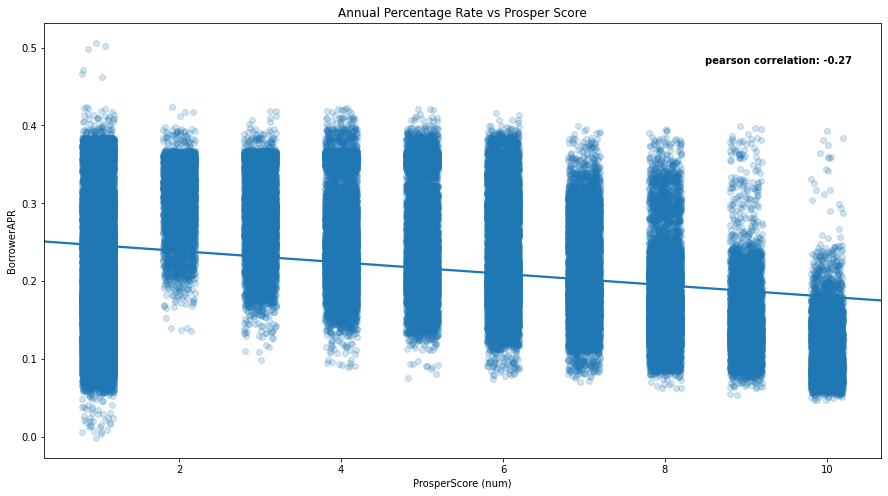

In [43]:
# calculate correlation
apr_score_corrr = round(df_clean['BorrowerAPR'].corr(df_clean['ProsperScore (num)'], method='pearson'), ndigits=2)

plt.figure(figsize=(15,8))
sb.regplot(data=df_clean, x='ProsperScore (num)', y='BorrowerAPR', x_jitter=0.2, y_jitter=0.01, scatter_kws={'alpha':0.2}, truncate=False)\
.set(title='Annual Percentage Rate vs Prosper Score')
plt.text(8.5, 0.48, "pearson correlation: "+str(apr_score_corrr), horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.show();

#### observations

The correlation is negative (-0.27), meaning that the lower the ProsperScore, the higher is the rate.

#### question

Does the StatedMonthlyIncome plays a role in determining the BorrowerAPR rate?

#### visualization

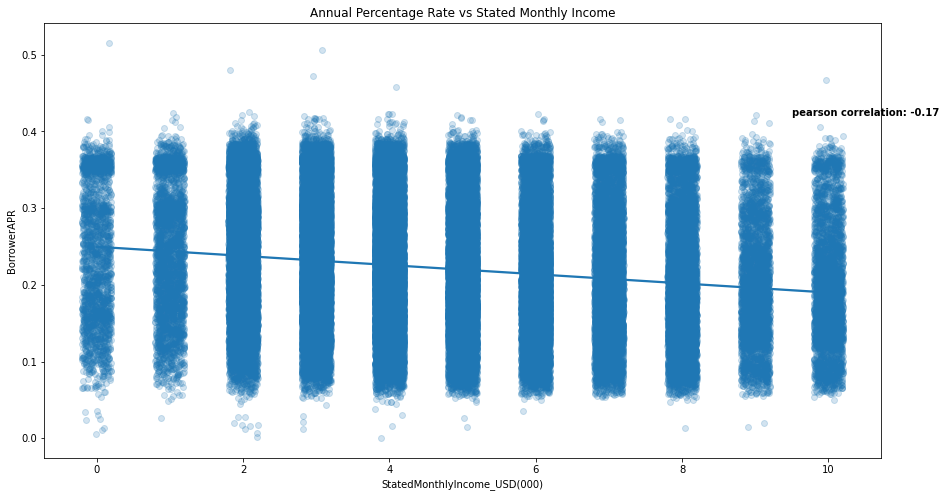

In [44]:
# as observed in the univariate investigation, the StatedMonthlyIncome
# has a long right tail, so here the data will be limited to the 0.99.9%
# percentile, as done also in the univariate exploration.

# using the created column in thousands of USD.
mask = df_clean['StatedMonthlyIncome_USD(000)']<=np.percentile(df_clean['StatedMonthlyIncome_USD(000)'], 90)

# calculate correlation
apr_score_corrr = round(df_clean['BorrowerAPR'][mask].corr(df_clean['StatedMonthlyIncome'][mask], method='pearson'), ndigits=2)

plt.figure(figsize=(15,8))
sb.regplot(data=df_clean[mask], x='StatedMonthlyIncome_USD(000)', y='BorrowerAPR', x_jitter=0.2, y_jitter=0.01, scatter_kws={'alpha':0.2}, truncate=True)\
.set(title='Annual Percentage Rate vs Stated Monthly Income')
plt.text(9.5, 0.42, "pearson correlation: "+str(apr_score_corrr), horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show();

#### observations

There is a weak negative correlation between the StatedMonthlyIncome and the Annual Percentage Rate (-0.17).

#### question

Is there any other insight on the relationship between BorrowerAPR and income, when looking for the income buckets in the IncomeRange column?

#### visutalization

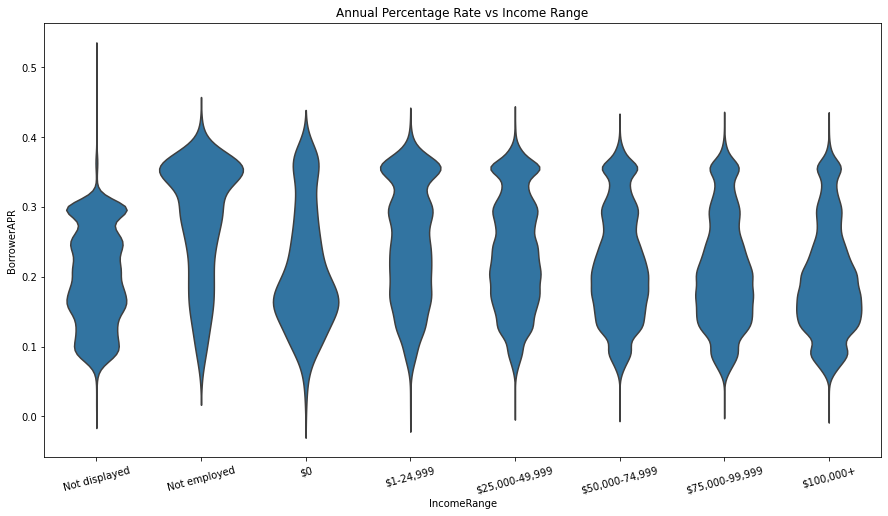

In [45]:
base_color = sb.color_palette()[0]

plt.figure(figsize=(15,8))
sb.violinplot(data=df_clean, x='IncomeRange', y='BorrowerAPR', color=base_color, inner=None)\
.set(title='Annual Percentage Rate vs Income Range')
plt.xticks(rotation=15);
plt.show();

#### observations

The shape observed for the "not employed" bucket seems to be the expected, with a larger interval for the higher rates. Also, this relationship appears to be valid for the next buckets as well, srhinking the higher rates and widening the lower rates as the salary goes up. But this does not apply for the $0 bucket, as this is the lowest income and the shape is wider in the lower rates.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> as observed, the BorrowerAPR decreases as the ProsperRating increases.
>
> That dynamic is also seen when looking to the StatedMonthlyIncome, although that does not seem to be valid for all income ranges, as borrowers with $0 of stated income have a better distribution than other with highers income ranges.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> As observed in the correlation matrix, the number of investors has a weak, and even negative, correlation with the EstimatedReturn. My initial supose about this relation would be that the higher a possible return, more investors would be willing to invest in it.

## Multivariate Exploration

#### question

Does anything saw in the correlation between BorrowerAPR and income changes, wheter the boolean variables ('IncomeVerifiable', 'CurrentlyInGroup', 'IsBorrowerHomeowner')are considered?

In [46]:
# FEATURE ENGINEERING

# create boolean ccolumns for the combination of each boolean variable ('IncomeVerifiable', 'CurrentlyInGroup', 'IsBorrowerHomeowner')

df_clean['IncomeVerifiable and InGroup'] = df_clean['IncomeVerifiable'] + df_clean['CurrentlyInGroup']
df_clean['IncomeVerifiable and IsHomeowner'] = df_clean['IncomeVerifiable'] + df_clean['IsBorrowerHomeowner']
df_clean['InGroup and IsHomeowner'] = df_clean['CurrentlyInGroup'] + df_clean['IsBorrowerHomeowner']
df_clean['IncomeVerifiable InGroup and IsHomeowner'] = df_clean['IncomeVerifiable'] + df_clean['CurrentlyInGroup'] + df_clean['IsBorrowerHomeowner']

In [47]:
# SAMPLE FOR THE MULTIVARIATE PLOTS

# as observed in the univariate investigation, the StatedMonthlyIncome
# has a long right tail, so for the multivariate plot I will limit the
# data to the 75 percentile (higher numbers make the plots too gibberish)

# Also, sample 3000 loans, so the resulting plots is clearer

# seed number for reproducibility
seed = 30
df_sample = income_percentile_filter(df_clean,75).sample(n=1000, replace=False, random_state=seed)

### plots for individual boolean variables

#### visualization (IncomeVerifiable)

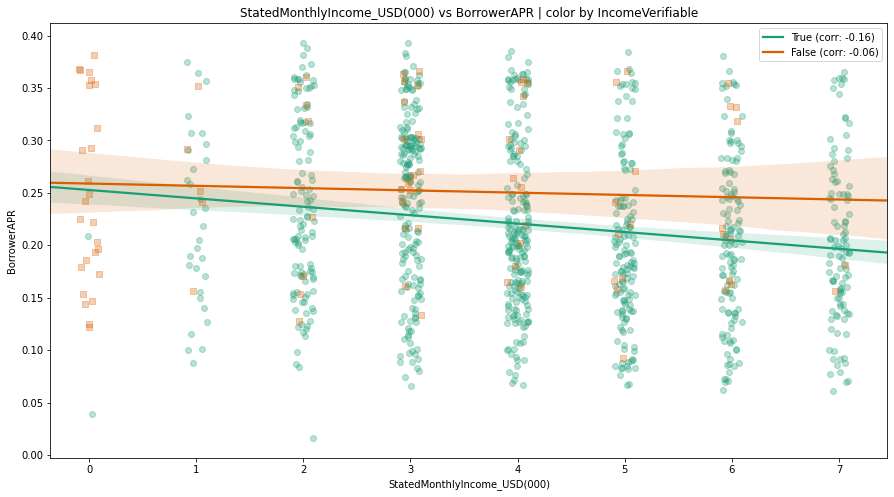

In [48]:
# changing the palette to differentiate between categorical variables
with sb.color_palette("Dark2"):
    regplot_three_var(df_sample, x='StatedMonthlyIncome_USD(000)', y='BorrowerAPR', third_var='IncomeVerifiable')

#### visualization (IsBorrowerHomeowner)

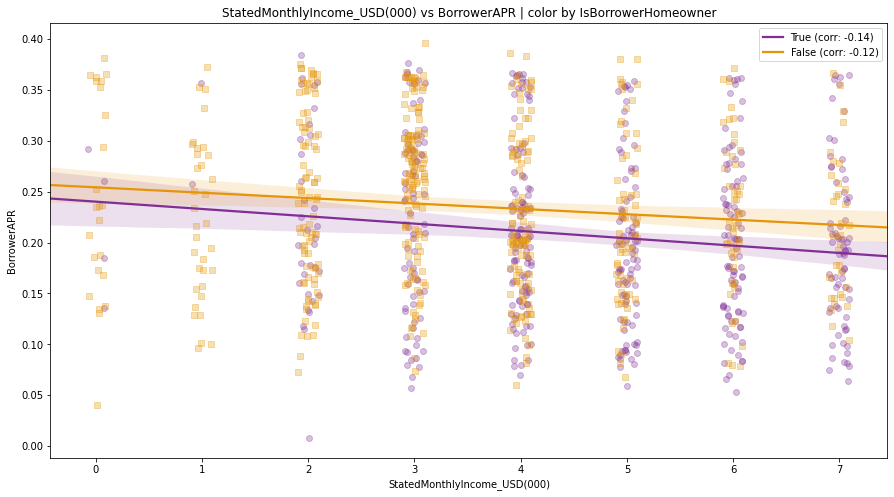

In [49]:
# changing the palette to differentiate between categorical variables
with sb.color_palette("CMRmap",2):
    regplot_three_var(df_sample, x='StatedMonthlyIncome_USD(000)', y='BorrowerAPR', third_var='IsBorrowerHomeowner')

#### visualization (CurrentlyInGroup)

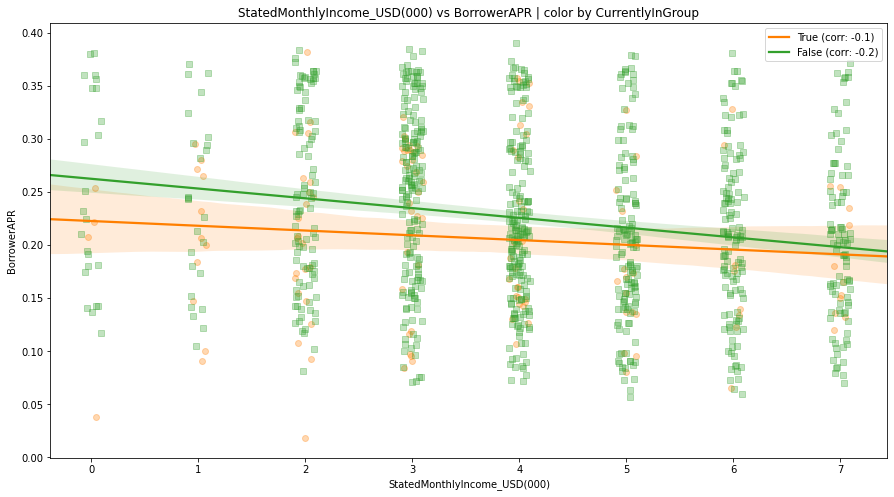

In [50]:
# changing the palette to differentiate between categorical variables
with sb.color_palette('Paired_r',2):
    regplot_three_var(df_sample, x='StatedMonthlyIncome_USD(000)', y='BorrowerAPR', third_var='CurrentlyInGroup')

#### observations

Despite the very low correlation between StatedMonthlyIncome and BorrowerAPR (-0.16 and -0.06 for verifiable and not verifiable income, respectvely), it is possible to see that a higher income, when verifiable, tends to decrease the APR faster than when not verifiable.

Similarly, being a homeowner has a small, but positive, impact on one's APR (-0.14 for homeowners vs -0.12 for not homeowners).

Finnaly, being in a group tend to be worse than not be, as for borrowers in a group the positive impact on the APR (negative correlation of 0.1) is lower than the positive impact of not being in any group (negative correlation of 0.2).

### plots for combinations of 2 and 3 boolean variables

#### visualization (combination of IncomeVerifiable and InGroup)

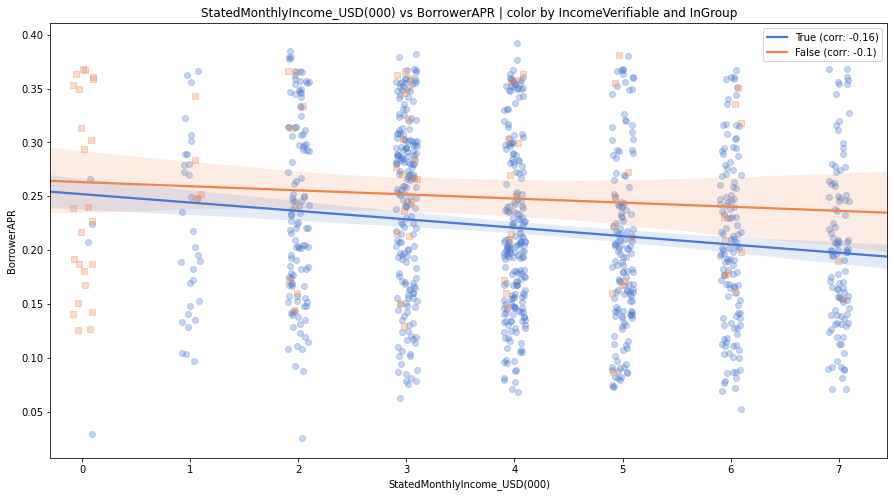

In [51]:
# changing the palette to differentiate between categorical variables
with sb.color_palette('muted',2):
    regplot_three_var(df_sample, x='StatedMonthlyIncome_USD(000)', y='BorrowerAPR', third_var='IncomeVerifiable and InGroup')

#### Visualization (combination of IncomeVerifiable and IsHomeowner)

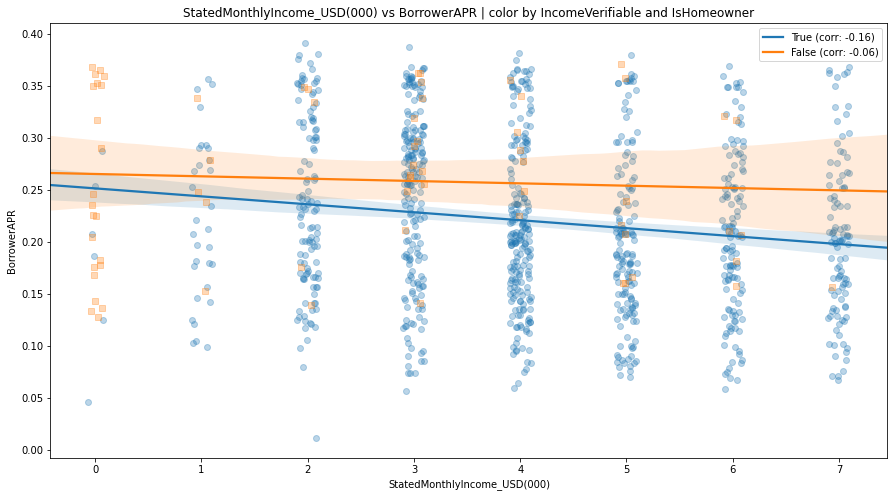

In [52]:
# changing the palette to differentiate between categorical variables
with sb.color_palette('tab10'):
    regplot_three_var(df_sample, x='StatedMonthlyIncome_USD(000)', y='BorrowerAPR', third_var='IncomeVerifiable and IsHomeowner')

#### visualization (combination of InGroup and IsHomeowner)

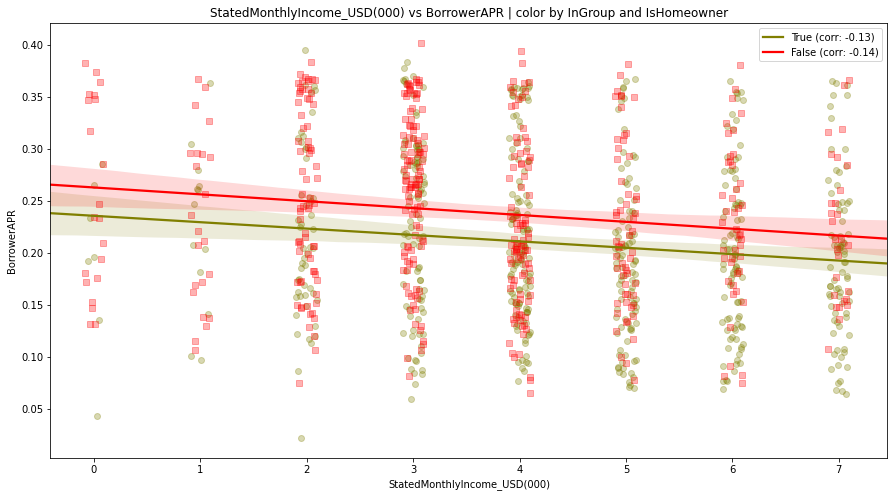

In [53]:
# changing the palette to differentiate between categorical variables
with sb.color_palette('brg_r',3):
    regplot_three_var(df_sample, x='StatedMonthlyIncome_USD(000)', y='BorrowerAPR', third_var='InGroup and IsHomeowner')

### plot for the combination of all boolean variables

#### visualization (combination of IncomeVerifiable, IsBorrowerInGroup and IsBorrowerHomeowner)

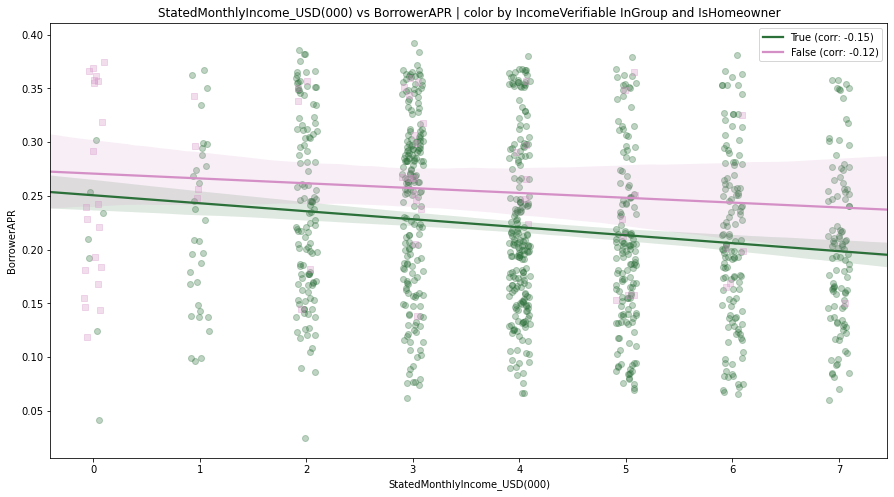

In [54]:
# changing the palette to differentiate between categorical variables
with sb.color_palette('cubehelix',2):
    regplot_three_var(df_sample, x='StatedMonthlyIncome_USD(000)', y='BorrowerAPR', third_var='IncomeVerifiable InGroup and IsHomeowner')

#### observation

Regarding the combination of 2 and 3 (all) of the boolean variables, the results are not far from the results when looking for each one individually. Only the CurrentlyInGroup variable demonstrated a correlation of 0.20 when the borrower is not part of a group (CurrentlyInGroup: False). Such correlation is just a bit higher than the -0.17 found without adding those third variables. None of the other combinations resulted in a correlation stronger than that -0.17.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> That weak relationship between BorrowerAPR and StatedMonthlIncome saw on the bivariate exploration (-0.17) is even weaker when added any single boolean variable into the mix: corr drops to -0.16 when IncomeVerifiable is True, to -0.14 when IsBorrowerHomeowner is True and -0.10 when CurrentlyInGroup is True.  
> Except for the CurrentlyInGroup, which showed a correlation of -0.2, the same also applies for any combination of two or all three of the boolean variables. The resulting correlation in those cases are all weaker than the -0.17 found earlier.

### Were there any interesting or surprising interactions between features?

> It was kind of surprising to see that having an verifiable income and/or being a homeowner doesn't possitivelly impact a BorrowersAPR

## Conclusions

> First, I choose the dataset with Prosper's loans information. Such dataset have 113,937 loan listings with 81 features.  
From the dataset I choose the variable "BorrowerAPR" as the variable of interest.
>
> During the data wrangling phase 6 issues were identified:
> * datetime columns formatted as strings instead of datetime.
> * numeric category column "listingcategory" needs apropriate translation.
> * 5 columns to convert ordered categorical types
> * The categorical column "ProsperScore" contained a invalid value (valid range from 1 to 10. There was 1,456 rows with a 11)
> * there were 25 nans rows in the variable of interest "BorrowerAPR"
> * there were 1,698 duplicated rows in the dataset
>
>The cleaning process was done following the define, code, test framework for each of the identified issues.
>
> Starting the exploratory phase with univariate plots, it was found that the mode of the BorrowerAPR is exactly 35,797% rate. Such rate represents 3.22% of all loans, strongly suggesting that this is some type of standard rate.
>
> Still in the univariate exploration, it was possible to understand a little of the profile of the Prosper user. More than 50% them listed the purpose of the loans as debt consolidation and more than 50% (not necessarily the same 50%) of them stated incomes in the range between 25k and 75k USD.
>
> Finally, during the univariate exploration it was possible to see that the histogram for the StatedMonthlyIncome variable is extremmely skewed to the right, becomming necessary to limit the data at some point to be able to plot and get meaningfull information. For the most part, to avoid overplotting, the limit was set at the 75% percentile (7k USD), while on others it was possible to limit at 99.9% (44k USD). The full range goes up to 1,750k USD.
>
>Advancing to the bivariate exploration, it was found that the "BorrowerAPR" have a high, or almost perfect, correlation with variables that seem to be affected by it ("BorrowerRate", "LenderYield", "EstimatedLoss", "EstimatedEffectiveYield" and "EstimatedReturn"), not variables that seem to, possiblly, affect it.
>
> Both the ProsperScore and the StatedMonthlyIncome, that innitially I though to be relevant for setting the BorrowerAPR, proved to have very low correlation with it (-0.27 and -0.17 for the ProsperScore and the StatedMonthlyIncome, respectivelly).
>
> Going forward, in the multivariable exploration I looked for correlations between the BorrowerAPR and StatedMonthlyIncome adding all combinations of the following boolean variables 'IncomeVerifiable', 'CurrentlyInGroup' and 'IsBorrowerHomeowner'.
>
> unfortunately, none of those attempts generated a higher correlation with the variable of interest.